In [4]:
import os
import gc
import time
import numpy as np
import pandas as pd
import threading as th

from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('train.csv',engine='c')

In [6]:
pickupDatetime  = pd.to_datetime(df.pickup_datetime)
dropoffDatetime = pd.to_datetime(df.dropoff_datetime)

dfDrop = df.drop(['id','pickup_datetime','dropoff_datetime'],axis=1)

# On reccréé des colonnes de pickup en séparant les informations de la date
dfDrop['pickupHour'] = pickupDatetime.dt.hour
dfDrop['pickupDayOfWeek'] = pickupDatetime.dt.dayofweek
dfDrop['pickupWeekOfYear'] = pickupDatetime.dt.weekofyear
dfDrop['pickupDayOfYear'] = pickupDatetime.dt.dayofyear
dfDrop['pickupMonth'] = pickupDatetime.dt.month

# Pareil pour le dropoff
dfDrop['dropoffHour'] = dropoffDatetime.dt.hour
dfDrop['dropoffDayOfWeek'] = dropoffDatetime.dt.dayofweek
dfDrop['dropoffWeekOfYear'] = dropoffDatetime.dt.weekofyear
dfDrop['dropoffDayOfYear'] = dropoffDatetime.dt.dayofyear
dfDrop['dropoffMonth'] = dropoffDatetime.dt.month

dfDrop = dfDrop[dfDrop.pickupWeekOfYear <= 52]

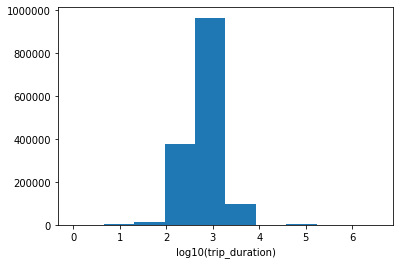

In [7]:
plt.hist(np.log10(df.trip_duration.values))
plt.xlabel('log10(trip_duration)')
plt.show()

In [8]:
# Avec ce graphique, on voit que la majoritée des valeurs se situent entre 10^2 et 10^(3,5) ~= 3200
# On peut donc supprimer les autres valeurs
dfGoodDurations = dfDrop[(dfDrop.trip_duration >= 100) & (dfDrop.trip_duration < 3200)]
print(dfDrop.shape)
print(dfGoodDurations.shape)

(1438617, 18)
(1401193, 18)


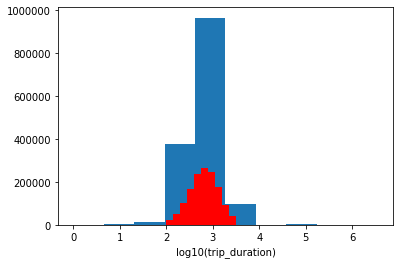

In [9]:
# Beaucoup de valeur ont été enlevé
plt.hist(np.log10(df.trip_duration.values))
plt.hist(np.log10(dfGoodDurations.trip_duration.values),color='red')
plt.xlabel('log10(trip_duration)')
plt.show()

In [10]:
# On transforme la colonne fwd_machin pour avoir des valeurs numérique...
labelEncoder = LabelEncoder()
dfGoodDurations.store_and_fwd_flag = labelEncoder.fit_transform(dfGoodDurations.store_and_fwd_flag)

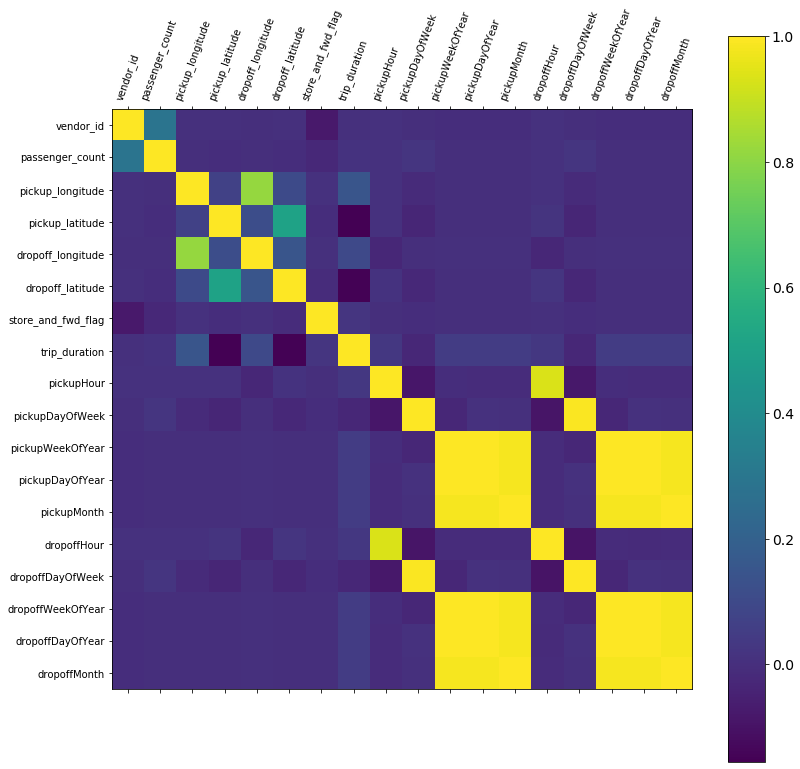

In [11]:
# On affiche la matrice de corélation pour voir quelles valeurs sont +/- corrélée entre elles
f = plt.figure(figsize=(13,13))
plt.matshow(dfGoodDurations[1:].corr(), fignum=f.number)
plt.xticks(range(dfGoodDurations[1:].shape[1]),labels=dfGoodDurations[1:].columns,rotation=70)
plt.yticks(range(dfGoodDurations[1:].shape[1]),dfGoodDurations[1:].columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

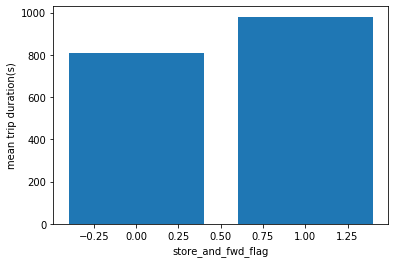

In [12]:
dfGroupByFlag = dfGoodDurations.groupby('store_and_fwd_flag')[['trip_duration']].mean()
dfGroupByFlag.reset_index(inplace=True)
plt.bar(dfGroupByFlag.store_and_fwd_flag.values,dfGroupByFlag.trip_duration.values)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('mean trip duration(s)')
plt.show()

In [13]:
dfUsable = dfGoodDurations.copy()
dfUsable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401193 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1401193 non-null  int64  
 1   passenger_count     1401193 non-null  int64  
 2   pickup_longitude    1401193 non-null  float64
 3   pickup_latitude     1401193 non-null  float64
 4   dropoff_longitude   1401193 non-null  float64
 5   dropoff_latitude    1401193 non-null  float64
 6   store_and_fwd_flag  1401193 non-null  int64  
 7   trip_duration       1401193 non-null  int64  
 8   pickupHour          1401193 non-null  int64  
 9   pickupDayOfWeek     1401193 non-null  int64  
 10  pickupWeekOfYear    1401193 non-null  int64  
 11  pickupDayOfYear     1401193 non-null  int64  
 12  pickupMonth         1401193 non-null  int64  
 13  dropoffHour         1401193 non-null  int64  
 14  dropoffDayOfWeek    1401193 non-null  int64  
 15  dropoffWeekOfYe

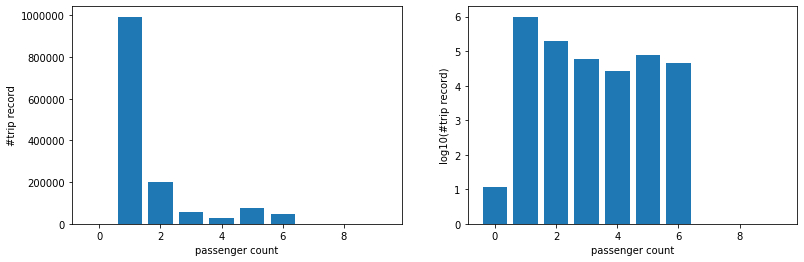

In [14]:
# On voit que trip_duration n'est pas corrélé linéairement avec beaucoup de variables. Il est donc probable que les algorithmes de regression linéaires ne donnent pas de bon résultats. On va essayer de trouver quelles variables sont intéressantes pour l'apprentissage.
dfGroupByPassengerCount = dfUsable.groupby(['passenger_count'])[['trip_duration']].count()
dfGroupByPassengerCount.reset_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,4))
ax1.set(xlabel='passenger count', ylabel='#trip record')
ax2.set(xlabel='passenger count', ylabel='log10(#trip record)')

ax1.bar(dfGroupByPassengerCount.passenger_count.values,dfGroupByPassengerCount.trip_duration.values)
ax2.bar(dfGroupByPassengerCount.passenger_count.values,np.log10(dfGroupByPassengerCount.trip_duration.values))

fig.show()

In [15]:
# On voit qu'il y a quelques valeurs pour 0 9 et 8 passagers. Comme on veut prédire des trajets, le but est qu'il y ait des passagers dans les taxi, on peut donc supprimer les lignes avec 0 passager, et 9 et 8, 1 seule entrée est innutile pour l'apprentissage
dfWithoutBadPCount = dfUsable[(dfUsable.passenger_count != 0) & (dfUsable.passenger_count <= 6)]

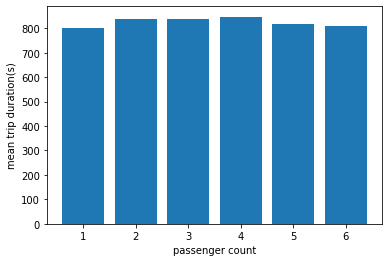

In [16]:
dfDurationByPassengerCount = dfWithoutBadPCount.groupby('passenger_count')[['trip_duration']].mean()
dfDurationByPassengerCount.reset_index(inplace=True)

plt.bar(dfDurationByPassengerCount.passenger_count.values, dfDurationByPassengerCount.trip_duration.values)
plt.xlabel('passenger count')
plt.ylabel('mean trip duration(s)')
plt.show()

In [17]:
# Les valeurs sont assez proches (entre 800 et 840), on peut donc supprimer le champs nombre de passagers qui n'a pas l'ai très intéressant
dfWithoutPCount = dfWithoutBadPCount.loc[:, dfWithoutBadPCount.columns != 'passenger_count']

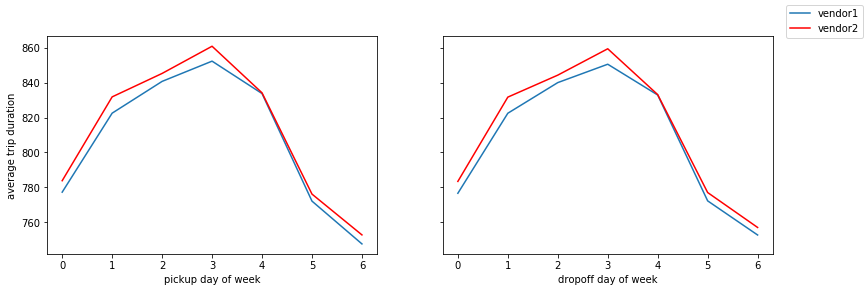

In [18]:
# On va regarder si les informations de dates sont importantes
tripDurationByVendorID_pickupDayOfWeek = dfWithoutPCount.groupby(['vendor_id', 'pickupDayOfWeek'])[['trip_duration']].mean()
tripDurationByVendorID_pickupDayOfWeek.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupDayOfWeek[tripDurationByVendorID_pickupDayOfWeek.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupDayOfWeek[tripDurationByVendorID_pickupDayOfWeek.vendor_id == 2]

tripDurationByVendorID_dropoffDayOfWeek = dfWithoutPCount.groupby(['vendor_id', 'dropoffDayOfWeek'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffDayOfWeek.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffDayOfWeek[tripDurationByVendorID_dropoffDayOfWeek.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffDayOfWeek[tripDurationByVendorID_dropoffDayOfWeek.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(13,4))
ax1.set(ylabel='average trip duration', xlabel='pickup day of week')
ax2.set(xlabel='dropoff day of week')

ax1.plot(pickupVendor1.pickupDayOfWeek,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupDayOfWeek,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffDayOfWeek,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffDayOfWeek,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

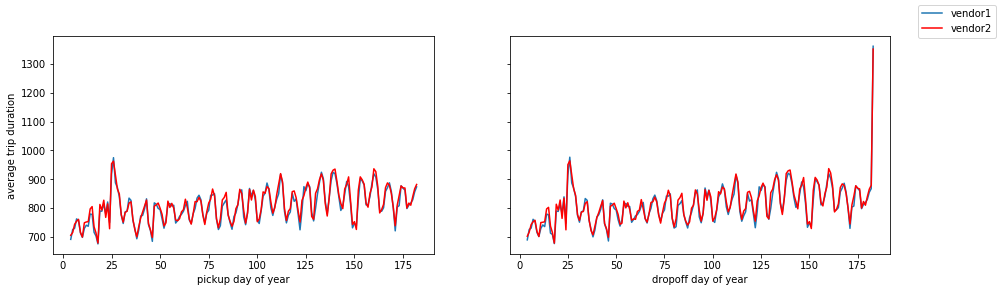

In [19]:
tripDurationByVendorID_pickupDayOfYear = dfWithoutPCount.groupby(['vendor_id', 'pickupDayOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_pickupDayOfYear.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupDayOfYear[tripDurationByVendorID_pickupDayOfYear.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupDayOfYear[tripDurationByVendorID_pickupDayOfYear.vendor_id == 2]

tripDurationByVendorID_dropoffDayOfYear = dfWithoutPCount.groupby(['vendor_id', 'dropoffDayOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffDayOfYear.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffDayOfYear[tripDurationByVendorID_dropoffDayOfYear.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffDayOfYear[tripDurationByVendorID_dropoffDayOfYear.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup day of year')
ax2.set(xlabel='dropoff day of year')

ax1.plot(pickupVendor1.pickupDayOfYear,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupDayOfYear,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffDayOfYear,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffDayOfYear,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

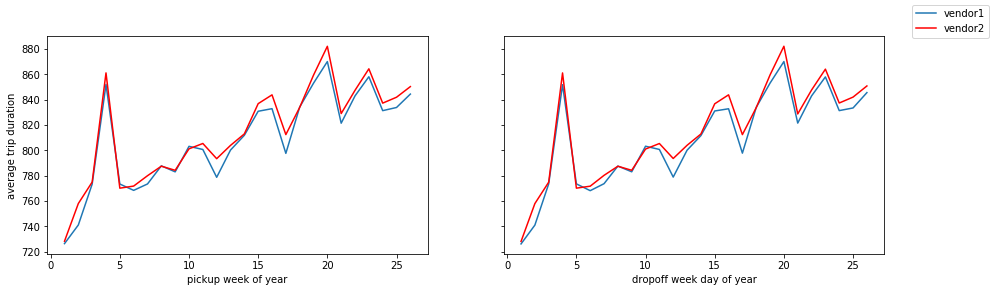

In [20]:
tripDurationByVendorID_pickupWeekOfYear = dfWithoutPCount.groupby(['vendor_id', 'pickupWeekOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_pickupWeekOfYear.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupWeekOfYear[tripDurationByVendorID_pickupWeekOfYear.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupWeekOfYear[tripDurationByVendorID_pickupWeekOfYear.vendor_id == 2]

tripDurationByVendorID_dropoffWeekOfYear = dfWithoutPCount.groupby(['vendor_id', 'dropoffWeekOfYear'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffWeekOfYear.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffWeekOfYear[tripDurationByVendorID_dropoffWeekOfYear.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffWeekOfYear[tripDurationByVendorID_dropoffWeekOfYear.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup week of year')
ax2.set(xlabel='dropoff week day of year')

ax1.plot(pickupVendor1.pickupWeekOfYear,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupWeekOfYear,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffWeekOfYear,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffWeekOfYear,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

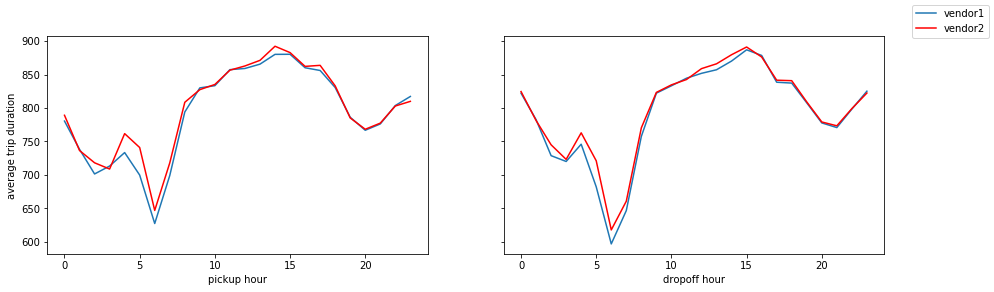

In [21]:
tripDurationByVendorID_pickupHour = dfWithoutPCount.groupby(['vendor_id', 'pickupHour'])[['trip_duration']].mean()
tripDurationByVendorID_pickupHour.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupHour[tripDurationByVendorID_pickupHour.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupHour[tripDurationByVendorID_pickupHour.vendor_id == 2]

tripDurationByVendorID_dropoffHour = dfWithoutPCount.groupby(['vendor_id', 'dropoffHour'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffHour.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffHour[tripDurationByVendorID_dropoffHour.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffHour[tripDurationByVendorID_dropoffHour.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup hour')
ax2.set(xlabel='dropoff hour')

ax1.plot(pickupVendor1.pickupHour,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupHour,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffHour,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffHour,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

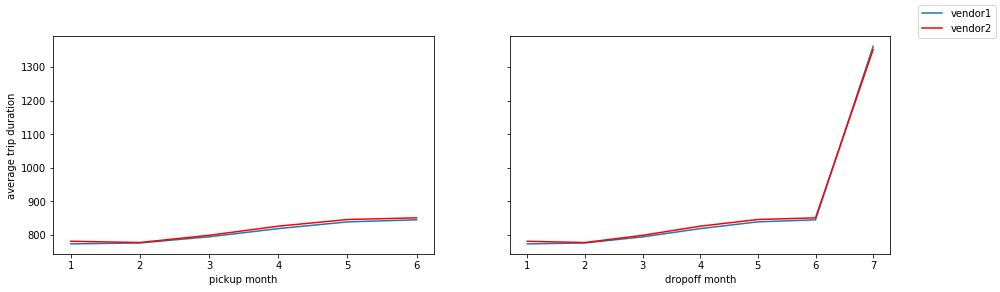

In [22]:
tripDurationByVendorID_pickupMonth = dfWithoutPCount.groupby(['vendor_id', 'pickupMonth'])[['trip_duration']].mean()
tripDurationByVendorID_pickupMonth.reset_index(inplace=True)
pickupVendor1 = tripDurationByVendorID_pickupMonth[tripDurationByVendorID_pickupMonth.vendor_id == 1]
pickupVendor2 = tripDurationByVendorID_pickupMonth[tripDurationByVendorID_pickupMonth.vendor_id == 2]

tripDurationByVendorID_dropoffMonth = dfWithoutPCount.groupby(['vendor_id', 'dropoffMonth'])[['trip_duration']].mean()
tripDurationByVendorID_dropoffMonth.reset_index(inplace=True)
dropoffVendor1 = tripDurationByVendorID_dropoffMonth[tripDurationByVendorID_dropoffMonth.vendor_id == 1]
dropoffVendor2 = tripDurationByVendorID_dropoffMonth[tripDurationByVendorID_dropoffMonth.vendor_id == 2]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(15,4))
ax1.set(ylabel='average trip duration', xlabel='pickup month')
ax2.set(xlabel='dropoff month')

ax1.plot(pickupVendor1.pickupMonth,pickupVendor1.trip_duration,label='vendor1')
ax1.plot(pickupVendor2.pickupMonth,pickupVendor2.trip_duration,color='red',label='vendor2')

ax2.plot(dropoffVendor1.dropoffMonth,dropoffVendor1.trip_duration)
ax2.plot(dropoffVendor2.dropoffMonth,dropoffVendor2.trip_duration,color='red')

fig.legend()
fig.show()

In [23]:
# On voit avec ces graphiques que globalement le vendeur 2 met un peu plus de temps que le vendeur 1 mais surtout que la date de pickup ou de dropoff donne des courbes presques parfaitement similaires, on peut donc n'en garder qu'une des deux. On choisit de garder pickup. De plus, les carbes sont presques plate pour les mois, l'écart est de moins de 100, je ne suis pas sûr qu'il soit cohérent de les garder
dropCols = ['vendor_id','dropoffDayOfWeek','dropoffWeekOfYear','dropoffDayOfYear','dropoffHour','dropoffMonth']
dfWithoutUseless = dfWithoutPCount.drop(dropCols,axis=1)

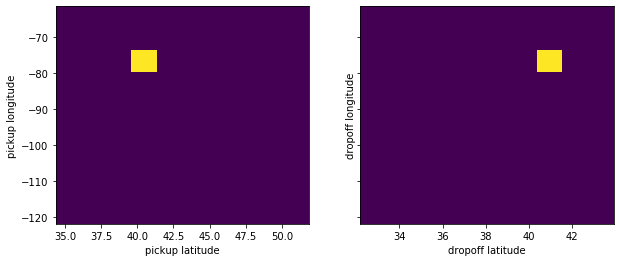

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),sharey=True)

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.hist2d(dfWithoutUseless.pickup_latitude,dfWithoutUseless.pickup_longitude,label='pickup coord')
ax2.hist2d(dfWithoutUseless.dropoff_latitude,dfWithoutUseless.dropoff_longitude,label='dropoff coord')
fig.show()

In [25]:
# On peut supprimer les lattitudes entre 40 et 42 et les longitudes entre -70 et -80
dfGood = dfWithoutUseless[(dfWithoutUseless.pickup_longitude >= -74.05) & (dfWithoutUseless.pickup_longitude <= -73.7) & (dfWithoutUseless.pickup_latitude >= 40.60) & (dfWithoutUseless.pickup_latitude <= 40.9) & (dfWithoutUseless.dropoff_longitude >= -74.05) & (dfWithoutUseless.dropoff_longitude <= -73.7) & (dfWithoutUseless.dropoff_latitude >= 40.60) & (df.dropoff_latitude <= 40.9)]
print(dfWithoutUseless.shape)
print(dfGood.shape)

(1401180, 11)
(1396288, 11)


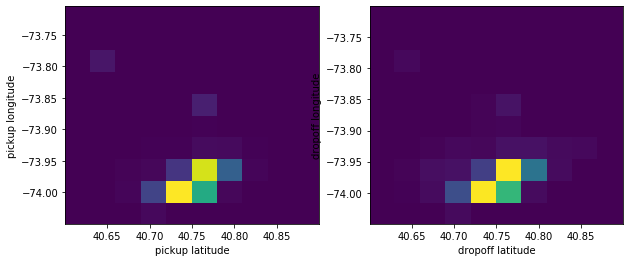

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.set(xlabel='pickup latitude',ylabel='pickup longitude')
ax2.set(xlabel='dropoff latitude',ylabel='dropoff longitude')

ax1.hist2d(dfGood.pickup_latitude,dfGood.pickup_longitude,label='pickup coord')
ax2.hist2d(dfGood.dropoff_latitude,dfGood.dropoff_longitude,label='dropoff coord')

fig.show()

In [27]:
# On a supprimer les locations trop éloignée, on va maintenant faire un cluqtering des pickups
kmeanPickup = KMeans(n_clusters=7,random_state=2,n_init=1).fit(dfGood[['pickup_longitude','pickup_latitude']])
kmeanDropoff = KMeans(n_clusters=7,random_state=2,n_init=1).fit(dfGood[['dropoff_longitude','dropoff_latitude']])

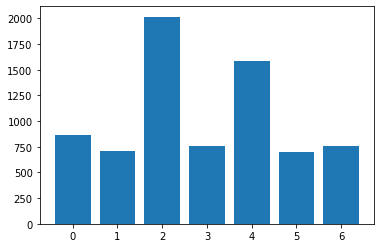

In [28]:
dfGood['clusterPickup'] = kmeanPickup.labels_

tripdurationByCluster = dfGood.groupby('clusterPickup')[['trip_duration']].mean()
tripdurationByCluster.reset_index(inplace=True)

plt.bar(tripdurationByCluster.clusterPickup.values, tripdurationByCluster.trip_duration.values)

plt.show()

In [29]:
# Maintenant que l'on a des données exploitable, on va pouvoir commencer l'entraînement (et croiser les doigts pour que ça marche mieux [edit] Oh que oui ça a mieu marché *_*)
X = dfGood.loc[:,dfGood.columns != 'trip_duration']
Y = dfGood.trip_duration
XTrain, XVal, YTrain, YVal = train_test_split(X,Y,train_size=0.8,random_state=19061996)

In [63]:
gc.collect()
#model = RandomForestRegressor(n_estimators=100,max_depth=40,random_state=19061996,n_jobs=os.cpu_count()*2).fit(XTrain,YTrain)
scaler = preprocessing.StandardScaler()
model = SVR(C=3800,epsilon=44,gamma='auto').fit(scaler.fit_transform(XTrain[:5000]),YTrain[:5000])

In [62]:
dfTest = pd.read_csv('test.csv',engine='c')
dfTestId = dfTest.id
dfTestPickupDatetime = pd.to_datetime(dfTest.pickup_datetime)
dfTestDrop = dfTest.drop(['id','vendor_id','passenger_count','pickup_datetime'],axis=1)

dfTestDrop['pickupHour'] = dfTestPickupDatetime.dt.hour
dfTestDrop['pickupDayOfWeek'] = dfTestPickupDatetime.dt.dayofweek
dfTestDrop['pickupWeekOfYear'] = dfTestPickupDatetime.dt.weekofyear
dfTestDrop['pickupDayOfYear'] = dfTestPickupDatetime.dt.dayofyear
dfTestDrop['pickupMonth'] = dfTestPickupDatetime.dt.month

kmeanPickupTest = KMeans(n_clusters=7,random_state=2,n_init=1).fit(dfTestDrop[['pickup_longitude','pickup_latitude']])
dfTest

dfTestDrop['clusterPickup'] = kmeanPickupTest.labels_

testLabelEncoder = LabelEncoder()
dfTestDrop.store_and_fwd_flag = testLabelEncoder.fit_transform(dfTestDrop.store_and_fwd_flag)

preds = model.predict(scaler.fit_transform(dfTestDrop))

result = pd.DataFrame()
result['id'] = dfTestId
result['trip_duration'] = preds
result.to_csv('sub.csv',index=0)

In [30]:
# On sauvegarde les données modifiée pour qu'elles soient accessible sans avoir à relancer touuuuuuuuut le notebook
XTrain.to_csv('XTrain.csv')
XVal.to_csv('XVal.csv')
YTrain.to_csv('YTrain.csv')
YVal.to_csv('YVal.csv')

In [3]:
### LANCER CETTE CELLULE APRES AVOIR EXTRAIT L'ARCHIVE ET LANCER LES PREMIERE CELLULE POUR AVOIR DIRECTEMENT ACCES AUX VALEURS PRETES POUR L'ENTRAINEMENT ###
# Lancer cette cellule pour charger les valeurs de val et de train. Il faut quand même exécuter la toute première cellule car c'est elle qui importe tous les packages dont python va avoir besoin
XTrain = pd.read_csv('XTrain.csv',engine='c',index_col=0)
YTrain = pd.read_csv('YTrain.csv',engine='c',index_col=0).values.ravel()
XVal = pd.read_csv('XVal.csv',engine='c',index_col=0)
YVal = pd.read_csv('YVal.csv',engine='c',index_col=0).values.ravel()

In [31]:
def checkAndZeroNegativeValues(valuesList):
    valuesList[valuesList < 0] = 0

def RSMLE(y_true, y_pred):
# Si y_pred contient des valeurs négatives on les met à zéro. Je ne sais pas si c'est une bonne soltion mais c'est celle que victoria avait donnée et ça vaut le coût d'essayer 
    checkAndZeroNegativeValues(y_pred)
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

def printTrainingInfo(timeFit,timePred,YPreds,YTrue=YVal):
    errorInSeconds = mean_absolute_error(YTrue,YPreds)
    
    error = RSMLE(YTrue,YPreds)

    endMsg = " t={:.2f}s (f={:.2f}s p={:.2f}s) e={:.5f} (={:.2f}s)\n".format(timeFit + timePred,timeFit,timePred,error,errorInSeconds)
    print(endMsg,end='')

def trainModelAndDisplayTrainingInfo(model,xTrain=XTrain,xVal=XVal,yTrain=YTrain,yVal=YVal):
    startFit = time.time()
    model.fit(xTrain,yTrain)
    endFit = time.time()

    startPred = time.time()
    preds = model.predict(xVal)
    endPred = time.time()

    printTrainingInfo(endFit-startFit,endPred-startPred,preds,yVal)

In [296]:
### TRAINING WITH RANDOM FOREST REGRESSOR ###
def train (n, d,jobs=None):
    startingMsg = "Starting n={} d={} ".format(n,d)
    print(startingMsg,end='')
    
    model = RandomForestRegressor(random_state=19061996,n_estimators=n, max_depth=d,n_jobs=jobs)

    trainModelAndDisplayTrainingInfo(model)

N = [10]
D = [10]

# +---------> D
# |
#\|/
# N
mask = [[1]]
print("training with {} threads".format(os.cpu_count()))
#Je vérifie que je n'est pas fait de la merde
assert(len(mask) == len(N))
for i in range(len(N)):
    assert(len(mask[i]) == len(D))

for i in range(len(N)):
    for j in range (len(D)):
        if mask[i][j] == 1:
            train(N[i],D[j],os.cpu_count())
    print('')

training with 4 threads
Starting n=10 d=10/Users/adrien/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
 t=45.91s (f=45.77s p=0.13s) e=0.52792 (=270.07s)



In [32]:
### TRAINING WITH SVR ###
# Les résultats de SVR ne sont pas indépendants de la répartition des données (c'est dit dans la doc de sklearn), il faut donc remettre X entre [-1,1], [0,1] ou avec une moyenne de 0 et un écart type de 1. Je les remet entre [0,1] car la fonction qui permet de calculer le score avec Kaggle (RSMLE) ne marche pas avec les nombres négatifs. Est ce que je suis intelligent et ait trouvé ça tout seul ?... ... ... Suspens... ... ... eh bas non, moi j'avais centré et réduit mes données, du coup j'avais des nombres négatifs, Python m'a insulté et j'ai compris
copyItem = 8000

scaler = preprocessing.StandardScaler()
SVRXTrain = scaler.fit_transform(XTrain[:copyItem])
SVRYTrain = YTrain[:copyItem].copy()

#gridSearch = GridSearchCV(SVR(epsilon=157,gamma='scale'),{'C':[23435,23436,23437,23438,23439,23440,23441,23442,23443,23444]'auto']},scoring=make_scorer(RSMLE,greater_is_better=False),n_jobs=os.cpu_count()*2,error_score=0,verbose=5).fit(SVRXTrain,SVRYTrain)

#print(gridSearch.best_params_, "{:.5f}".format(-gridSearch.best_score_))
gridSearch = SVR(C=5314,epsilon=53.86,gamma='scale').fit(SVRXTrain,SVRYTrain)

In [33]:
printTrainingInfo(0,0,gridSearch.predict(scaler.fit_transform(XVal)),YVal)

t=0.00s (f=0.00s p=0.00s) e=0.42104 (=217.72s)


In [53]:
gc.collect()

5245